## Quantile Recalibration Training demo

This notebook contains minimal code to train a model using Quantile Recalibration Training (QRT) with PyTorch Lightning.
The implementation of the recalibrator is available in the file `QRT.py`.

In [1]:
import warnings
import logging
import shutil
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal, Categorical, MixtureSameFamily
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.utilities.warnings import PossibleUserWarning

from QRT import Recalibrator
from datamodule import CustomDataModule

pl.seed_everything(0)
warnings.filterwarnings('ignore', category=PossibleUserWarning)
logging.getLogger('pytorch_lightning').setLevel(logging.WARNING)

Global seed set to 0


### Data loading

We select the dataset `house_prices_nominal`, where QRT demonstrated a significant NLL improvement in our paper.

In [2]:
datamodule = CustomDataModule(ds_id=361083)

### Metrics

In [3]:
def compute_nll(dist, y):
    return -dist.log_prob(y).mean()

def compute_pce(dist, y):
    pit = dist.cdf(y)
    sorted_pit = torch.sort(pit, dim=-1)[0]
    n = pit.shape[-1]
    lin = (torch.arange(n) + 1) / (n + 1)
    return (sorted_pit - lin).abs().mean()

### Base model

In [4]:
class MixturePredictionMLP(nn.Module):
    def __init__(self, input_size=1, hidden_sizes=[128, 128, 128], drop_prob=0.1, mixture_size=3):
        super().__init__()
        self.mixture_size = mixture_size
        self.hidden_layers = nn.ModuleList()
        current_input_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(current_input_size, hidden_size))
            current_input_size = hidden_size
        self.dropout_layer = nn.Dropout(p=drop_prob)
        self.output_layer = nn.Linear(current_input_size, 3 * mixture_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)
        x = self.dropout_layer(x)
        x = self.output_layer(x)
        means, rhos, mix_logits = torch.split(x, 3, dim=-1)
        stds = F.softplus(rhos) + 1e-4
        return MixtureSameFamily(Categorical(logits=mix_logits), Normal(means, stds))

### Training procedure

In [5]:
class QRTModule(pl.LightningModule):
    def __init__(self, model, qrt=False, qr=False):
        """
        qrt: whether to use the current batch for recalibration during training
        qr: whether to use the calibration dataset for post-hoc recalibration
        """
        super().__init__()
        self.model = model
        self.qrt = qrt
        self.qr = qr
        self.posthoc_calibration_map = None
    
    def forward(self, x):
        dist = self.model(x)
        if self.posthoc_calibration_map is None:
            self.build_posthoc_calibration_map()
        if self.qrt or self.qr:
            dist = self.posthoc_calibration_map(dist)
        return dist

    def training_step(self, batch, batch_idx):
        x, y = batch
        dist = self.model(x)
        if self.qrt:
            pit = dist.cdf(y)
            dist = Recalibrator(pit)(dist)
        loss = compute_nll(dist, y)
        return loss

    def on_validation_start(self):
        if self.qrt:
            x, y = next(iter(self.trainer.datamodule.train_dataloader()))
            dist = self.model(x)
            pit = dist.cdf(y)
            self.calibration_map = Recalibrator(pit)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        dist = self.model(x)
        if self.qrt:
            dist = self.calibration_map(dist)
        loss = compute_nll(dist, y)
        self.log('val/nll', loss, on_step=False, on_epoch=True)
        return loss
    
    def build_posthoc_calibration_map(self):
        if self.qrt or self.qr:
            if self.qr:
                # In case of QR (potientially with QRT), we use the calibration dataset for recalibration
                x, y = next(iter(self.trainer.datamodule.calib_dataloader()))
            elif self.qrt:
                # In case QRT is enabled without QR, we use the training dataset for recalibration
                x, y = next(iter(self.trainer.datamodule.train_dataloader()))
            with torch.no_grad():
                dist = self.model(x)
            pit = dist.cdf(y)
            self.posthoc_calibration_map = Recalibrator(pit)

    def on_test_start(self):
        self.build_posthoc_calibration_map()
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        dist = self.model(x)
        if self.qrt or self.qr:
            dist = self.posthoc_calibration_map(dist)
        loss = compute_nll(dist, y)
        pce = compute_pce(dist, y)
        self.log('test/nll', loss, on_step=False, on_epoch=True)
        self.log('test/pce', pce, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

In [6]:
def train(model):
    mc = ModelCheckpoint(
        dirpath='checkpoints',
        mode='min',
        monitor='val/nll',
        save_top_k=1,
        save_last=False,
        verbose=False,
        auto_insert_metric_name=False,
    )

    es = EarlyStopping(
        mode='min',
        monitor='val/nll',
        patience=15,
    )

    trainer = Trainer(
        max_epochs=-1,
        callbacks=[mc, es],
        accelerator='cpu',
        devices=1,
        check_val_every_n_epoch=2,
        enable_model_summary=False,
        enable_progress_bar=False,
        logger=False,
    )

    trainer.fit(model=model, datamodule=datamodule)
    trainer.test(ckpt_path='best', datamodule=datamodule, verbose=False)
    shutil.rmtree('checkpoints')
    return trainer

### Vanilla model

In [7]:
mlp = MixturePredictionMLP(datamodule.x_size)
# We don't handle it here for simplicity, but in the paper the vanilla module also had access to the
# calibration dataset during training.
model = QRTModule(mlp)
trainer = train(model)
trainer.logged_metrics

/home/victor/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/victor/Downloads/quantile-recalibration-training/demo/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


{'test/nll': tensor(0.1317), 'test/pce': tensor(0.0189)}

### Quantile Recalibration model

In [8]:
mlp = MixturePredictionMLP(datamodule.x_size)
model = QRTModule(mlp, qr=True)
trainer = train(model)
trainer.logged_metrics

{'test/nll': tensor(0.1274), 'test/pce': tensor(0.0262)}

### Quantile Recalibration Training model

In [9]:
mlp = MixturePredictionMLP(datamodule.x_size)
model = QRTModule(mlp, qrt=True, qr=True)
trainer = train(model)
trainer.logged_metrics

{'test/nll': tensor(0.0299), 'test/pce': tensor(0.0177)}

### Results on multiple runs

To obtain stronger results, we repeat the experiments 50 times.

In [10]:
def collect_metrics_on_multiple_runs(data, model_name, nb_runs=50, **kwargs):
    pl.seed_everything(0)
    metrics_dict = defaultdict(list)
    for _ in tqdm(range(nb_runs)):
        mlp = MixturePredictionMLP(datamodule.x_size)
        model = QRTModule(mlp, **kwargs)
        trainer = train(model)
        metrics = trainer.logged_metrics
        for k, v in metrics.items():
            data['model'].append(model_name)
            data['metric'].append(k)
            data['value'].append(v.item())
    return metrics_dict

In [11]:
data = {'model': [], 'metric': [], 'value': []}
collect_metrics_on_multiple_runs(data, 'vanilla')
collect_metrics_on_multiple_runs(data, 'QR', qr=True)
collect_metrics_on_multiple_runs(data, 'QRT', qrt=True, qr=True)
df = pd.DataFrame(data)
aggfunc = lambda x: f'{np.mean(x):.4f} ± {sem(x):.4f}'
df.pivot_table(index='model', columns='metric', values='value', aggfunc=aggfunc)

Global seed set to 0
  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [08:56<00:00, 10.74s/it]
Global seed set to 0
100%|██████████| 50/50 [09:14<00:00, 11.09s/it]
Global seed set to 0
100%|██████████| 50/50 [10:24<00:00, 12.49s/it]


metric,test/nll,test/pce
model,,
QR,0.0972 ± 0.0078,0.0195 ± 0.0009
QRT,0.0281 ± 0.0031,0.0215 ± 0.0005
vanilla,0.0951 ± 0.0054,0.0272 ± 0.0020


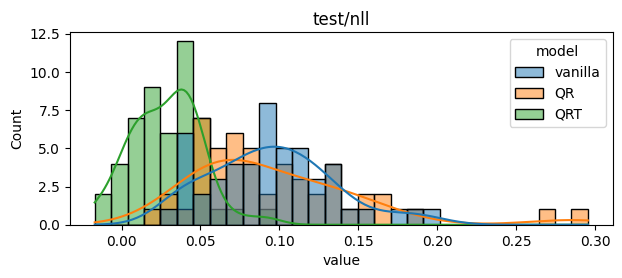

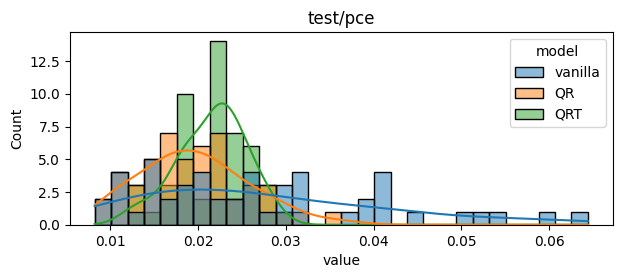

In [12]:
for metric in df['metric'].unique():
    fig, ax = plt.subplots(figsize=(7, 2.5))
    sns.histplot(data=df.query('metric == @metric'), x='value', hue='model', kde=True, bins=30, legend=True)
    ax.set_title(metric)

We notice that the NLL of QRT is significantly improved compared to both vanilla and QR. In this case, the PCE of QRT is slightly worse than QR but not significantly different. Both QRT and QR obtain an improved PCE compared to the vanilla model.